In [1]:
"""
Exploratory Data Analysis for Wine Data
"""
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

import pandas as pd
from pandas_profiling import ProfileReport

#load data to pandas
reader = DataFileReader(open("assignment/takehome.avro", "rb"), DatumReader())

#save to pickled df
records = [record for record in reader]
df = pd.DataFrame.from_records(records)
df.to_pickle("df.pkl")

#quick info
print(df.head())
print(df.info())

#look at large or small values
print(df[(df['rating']<3) | (df['rating']>6)])
test = df

#create test urls in an excel file for later
test['url'] = df.apply(lambda x: "http://127.0.0.1:8080/rating/prediction.json?ph=%s&brightness=%s&chlorides=%s&sugar=%s&sulfates=%s&acidity=%s" % (x['ph'], x['brightness'], x['chlorides'], x['sugar'], x['sulfates'], x['acidity']), axis=1)
test.to_excel('text.xlsx')

#pandas profiling
ProfileReport(df)

#save to html
profile = df.profile_report(title='Wine Profiling Report')
profile.to_file(output_file="wine_profiling_report.html")


   brightness  chlorides   ph  sugar  sulfates  acidity  rating
0           2       0.03  3.3    8.1       1.2     14.5       4
1           1       0.03  2.8   11.0       1.1     10.0       3
2           8       0.03  2.2    7.3       1.4      5.0       1
3          10       0.03  3.4    1.1       0.1     12.0       3
4           5       0.05  2.9   12.9       0.2     12.5       2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   brightness  5000 non-null   int64  
 1   chlorides   5000 non-null   float64
 2   ph          5000 non-null   float64
 3   sugar       5000 non-null   float64
 4   sulfates    5000 non-null   float64
 5   acidity     4506 non-null   float64
 6   rating      5000 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 273.6 KB
None
      brightness  chlorides   ph  sugar  sulfates  acidity  rating
2              8 

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   brightness  5000 non-null   int64  
 1   chlorides   5000 non-null   float64
 2   ph          5000 non-null   float64
 3   sugar       5000 non-null   float64
 4   sulfates    5000 non-null   float64
 5   acidity     4506 non-null   float64
 6   rating      5000 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 273.6 KB
train sample weights are [0.55555556 0.83507307 0.75757576 ... 0.52219321 0.55555556 0.37071362]
full sample weights are [0.37313433 0.51546392 2.10970464 ... 0.37313433 0.57012543 0.37313433]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
The total space of parameters 1 is smaller than n_iter=150. Running 1 iterations. For exhaustive searches, use GridSearchCV.
The least populated class in y has only 1 members, which is less than n_splits=5.
One or more of

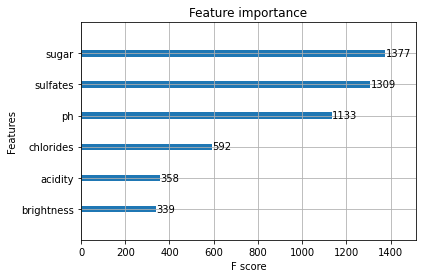

{'objective': 'multi:softprob', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.1, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': 3, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 1, 'tree_method': 'auto', 'validate_parameters': 1, 'verbosity': None}
[21:01:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pas

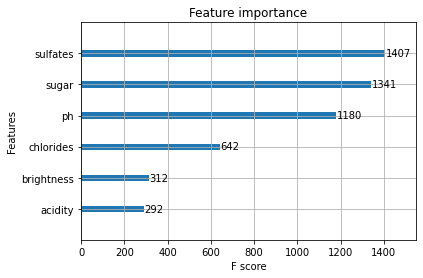

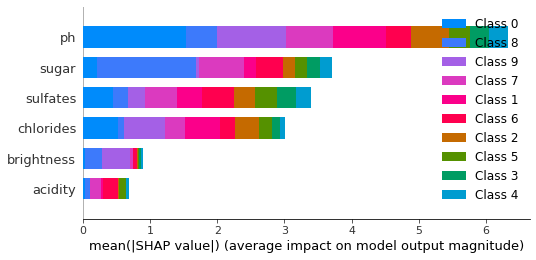

In [2]:
"""
Trains and saves an XGBoost model on the wine data. 

The final model fit on all data is saved as xgb_full_train.json for use in the microservice.
"""
# %% Load Modules
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot as plt
import shap 
from datetime import datetime

# %% Load Dataframe
df = pd.read_pickle("df.pkl")
df.info()
X = df.drop('rating', axis=1)
y = df.pop('rating')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute sample weights
sw_train = compute_sample_weight("balanced", y_train)
print(f"train sample weights are {sw_train}")

# Compute full dataset weights
sw_full = compute_sample_weight("balanced", y)
print(f"full sample weights are {sw_full}")

# %% CV training to optimize hyperparameters

clf = xgb.XGBClassifier()

# best params for quick rerun of code
parameters = {
     "learning_rate"    : [0.1],
     "max_depth"        : [4],
     "min_child_weight" : [3],
     "gamma"            : [0.1],
     "colsample_bytree" : [1],
     "n_estimators"     : [50]
     }

# uncomment for actual search
# parameters = {
#      "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
#      "min_child_weight" : [ 1, 3, 5, 7 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
#      "n_estimators"     : [25, 50, 100, 150]
#      }

cv = RandomizedSearchCV(clf,
                    parameters,n_iter=150, n_jobs=3,
                    scoring="neg_log_loss",
                    cv=5, verbose=10,
                    )

start_time = datetime.now() 
cv.fit(X_train, y_train, sample_weight = sw_train )
time_elapsed = datetime.now() - start_time 
print('Time elapsed for cv fit is (hh:mm:ss.ms) {}'.format(time_elapsed))

# %% Save the best estimator model 
bst = cv.best_estimator_
bst.save_model('best_xgb_cv.json')
xgb_latest = xgb.XGBClassifier(n_jobs=3)
xgb_latest.load_model("best_xgb_cv.json")

# %% Validate model on holdout data
preds = xgb_latest.predict(X_test)
report = classification_report(y_test, preds)
print(report)

xgb.plot_importance(xgb_latest)
plt.show()

# %% Retrain on all data and export model
print(xgb_latest.get_params())
xgb_latest.fit(X, y, sample_weight= sw_full)
print(xgb_latest.get_params())
xgb_latest.save_model('xgb_full_train.json')
# %% Sanity check for changes from full train
xgb.plot_importance(xgb_latest)
plt.show()

#  %% Shap interpretation of final fit
explainer = shap.TreeExplainer(xgb_latest)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
 


In [3]:
"""
With a model made, create a service which responds to HTTP requests. We only need one endpoint:

`[GET] /rating/prediction.json`

Return a JSON document with the rating prediction. You can assume that the attributes are provided as URL encoded parameters like `/rating/predcition.json?ph=3&brightness=5` and you should expect all 6 parameters above to be provided. If a parameter is missing, return a 400 status code.
"""

from flask import Flask, jsonify
import pandas as pd
import xgboost as xgb
from flask_parameter_validation import ValidateParameters, Route, Json, Query

app = Flask(__name__)

@app.route('/')
def index():
    return 'Welcome to the Wine Predictor Microservice'

@app.route('/rating/prediction.json', methods=['GET'])
@ValidateParameters() #parameter validation
def predict(
        brightness: float = Query(),
        chlorides: float = Query(),
        ph: float = Query(),
        sugar: float = Query(),
        sulfates: float = Query(),
        acidity: float = Query()
        ):
    input_parameters = {
        'brightness': [brightness],
        'chlorides': [chlorides],
        'ph': [ph],
        'sugar': [sugar],
        'sulfates': [sulfates],
        'acidity': [acidity]
    }
    print(input_parameters)
    query_df = pd.DataFrame.from_dict(input_parameters)
    print(query_df)
    prediction = clf.predict(query_df)
    print(f"Prediction is {prediction}")
    return jsonify({'prediction': int(prediction)})
    
#a few test queries. text.xlsx contains urls for the original set. 
# http://127.0.0.1:8080/rating/prediction.json?ph=2.0999999046325684&brightness=5.0&chlorides=0.03999999910593033&sugar=13.0&sulfates=1.2999999523162842&acidity=4.5 (actual is 1)
# http://127.0.0.1:8080/rating/prediction.json?ph=5&brightness=3&chlorides=2&sugar=2&sulfates=15&acidity=12
# http://127.0.0.1:8080/rating/prediction.json?ph=1&brightness=2&chlorides=3&sugar=4&sulfates=5&acidity=6
# http://127.0.0.1:8080/rating/prediction.json?ph=3.5&brightness=2&chlorides=0&sugar=9.1&sulfates=1.5&acidity=15 (real is 6)
# http://127.0.0.1:8080/rating/prediction.json?ph=2.4&brightness=1&chlorides=0.02&sugar=0&sulfates=1.5&acidity=8 (real is 5)
# http://127.0.0.1:8080/rating/prediction.json?ph=2&brightness=9&chlorides=0.02&sugar=9.7&sulfates=0.9&acidity=4 (real is 7)
#http://127.0.0.1:8080/rating/prediction.json?ph=1&brightness=2&chlorides=3&sugar=4&sulfates=5&acidity=6 (fake data)

if __name__ == '__main__':
    # load model
    clf = xgb.XGBClassifier()
    clf.load_model('xgb_full_train.json')
    print(clf)
    app.run(port=8080)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)
 * Serving Flask app "2_microservice" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:8080/ (Press CTRL+C to quit)
127.0.0.1 - - [10/Mar/2021 21:06:53] "GET /rating/prediction.json?ph=2.0999999046325684&brightness=5.0&chlorides=0.03999999910593033&sugar=13.0&sulfates=1.2999999523162842&acidity=4